In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [16]:
# 1. Daten laden
required_files = ["umsatzdaten_gekuerzt.csv", "kiwo.csv", "wetter.csv", "Data Import and Preparation/feiertage.csv"]
for file in required_files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"Datei '{file}' nicht gefunden.")

umsatzdaten = pd.read_csv("umsatzdaten_gekuerzt.csv")
kiwo_data = pd.read_csv("kiwo.csv")
wetter_data = pd.read_csv("wetter.csv")
feiertage = pd.read_csv("Data Import and Preparation/feiertage.csv")

In [17]:
# 2. Datum anpassen und konvertieren
umsatzdaten['Datum'] = pd.to_datetime(umsatzdaten['Datum'], errors='coerce')
kiwo_data['Datum'] = pd.to_datetime(kiwo_data['Datum'], errors='coerce')
wetter_data['Datum'] = pd.to_datetime(wetter_data['Datum'], errors='coerce')

# Feiertags-Datum anpassen
feiertage['Datum'] = feiertage['Datum'].apply(
    lambda x: f"{str(x).strip()} 2017" if isinstance(x, str) else None
)
feiertage['Datum'] = pd.to_datetime(feiertage['Datum'], format='%d. %b %Y', errors='coerce')

In [18]:
# 3. Daten zusammenführen
merged_data = umsatzdaten.merge(kiwo_data, on='Datum', how='left')
merged_data = merged_data.merge(wetter_data, on='Datum', how='left')
merged_data = merged_data.merge(feiertage[['Datum', 'Name']], on='Datum', how='left')

In [20]:
# 4. Zusätzliche Variablen erstellen
merged_data['Wochentag'] = merged_data['Datum'].dt.day_name()
merged_data['Wochentag_Nummer'] = merged_data['Datum'].dt.weekday
merged_data['Monat'] = merged_data['Datum'].dt.month
merged_data['Quartal'] = merged_data['Datum'].dt.quarter
merged_data['Ist_Wochenende'] = merged_data['Wochentag'].isin(['Saturday', 'Sunday']).astype(int)
merged_data['Ist_Feiertag'] = merged_data['Name'].notnull().astype(int)

def categorize_temperature(temp):
    if temp < 10:
        return "Kalt"
    elif 10 <= temp < 20:
        return "Mild"
    else:
        return "Warm"

merged_data['Temperatur_Kategorie'] = merged_data['Temperatur'].apply(categorize_temperature)
merged_data['Feiertagsnaehe'] = (
    (merged_data['Ist_Feiertag'] == 1) |
    (merged_data['Datum'] - pd.Timedelta(days=1)).isin(feiertage['Datum']) |
    (merged_data['Datum'] + pd.Timedelta(days=1)).isin(feiertage['Datum'])
).astype(int)
merged_data['Umsatz_Trend_7_Tage'] = merged_data['Umsatz'].rolling(window=7, min_periods=1).mean()

# Fehlende Werte behandeln
merged_data.fillna(0, inplace=True)

In [21]:
# 5. Datensatz teilen
train_data = merged_data[(merged_data['Datum'] >= '2013-07-01') & (merged_data['Datum'] <= '2017-07-31')]
validation_data = merged_data[(merged_data['Datum'] >= '2017-08-01') & (merged_data['Datum'] <= '2018-07-31')]

In [22]:
# 6. Lineares Modell erstellen
features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Ist_Wochenende']
X_train = train_data[features]
y_train = train_data['Umsatz']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# 7. Adjustiertes R² berechnen
n = len(y_train)
p = X_train.shape[1]
r2 = model.score(X_train, y_train)
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Ergebnisse ausgeben
print("R²:", r2)
print("Adjustiertes R²:", adj_r2)

R²: 0.07190310112971954
Adjustiertes R²: 0.07140930123673184


In [24]:
# 8. Ergebnisse speichern
output_dir = "Baseline Model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Ergebnisse dokumentieren
with open(os.path.join(output_dir, "results.txt"), "w") as f:
    f.write(f"R²: {r2}\n")
    f.write(f"Adjustiertes R²: {adj_r2}\n")

train_data.to_csv(os.path.join(output_dir, "train_data.csv"), index=False)
validation_data.to_csv(os.path.join(output_dir, "validation_data.csv"), index=False)

In [25]:
# 9. Sample Submission laden
submission_file = "sample_submission.csv"
if not os.path.exists(submission_file):
    raise FileNotFoundError(f"Datei '{submission_file}' nicht gefunden.")

submission = pd.read_csv(submission_file)

# IDs aus der sample_submission.csv übernehmen
submission_ids = submission['id']

# Umsatz mit dem Modell vorhersagen
X_val = validation_data[features]
y_pred = model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(submission):
    y_pred = y_pred[:len(submission)]

# Umsatzwerte in die Submission-Datei einfügen
submission['Umsatz'] = y_pred

# IDs aus der sample_submission.csv wiederherstellen
submission['id'] = submission_ids

# Datum-Spalte entfernen, falls vorhanden
if 'Datum' in submission.columns:
    submission = submission.drop(columns=['Datum'])

# Submission speichern
submission.to_csv("submission.csv", index=False)

print("Sample Submission aktualisiert und gespeichert als 'submission.csv'.")
print("Berechnungen abgeschlossen und Ergebnisse gespeichert.")

Sample Submission aktualisiert und gespeichert als 'submission.csv'.
Berechnungen abgeschlossen und Ergebnisse gespeichert.


Epoch 1/50


c:\Users\ayham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 52076.9961 - mae: 175.3464 - val_loss: 17061.6855 - val_mae: 102.0438
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21322.2715 - mae: 112.5452 - val_loss: 16021.5762 - val_mae: 99.8225
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21003.5039 - mae: 111.9030 - val_loss: 15550.3203 - val_mae: 97.7971
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21907.9414 - mae: 112.2069 - val_loss: 15529.5703 - val_mae: 98.6447
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19919.9785 - mae: 110.8761 - val_loss: 15314.8525 - val_mae: 97.5562
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20959.6270 - mae: 110.9221 - val_loss: 15291.7275 - val_mae: 97.8064
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19466.8418 - mae: 108.2399 - val_loss: 15685.2939 - val_mae: 100.7231
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19749.5137 - mae: 110.5141 - val_loss: 15397.2

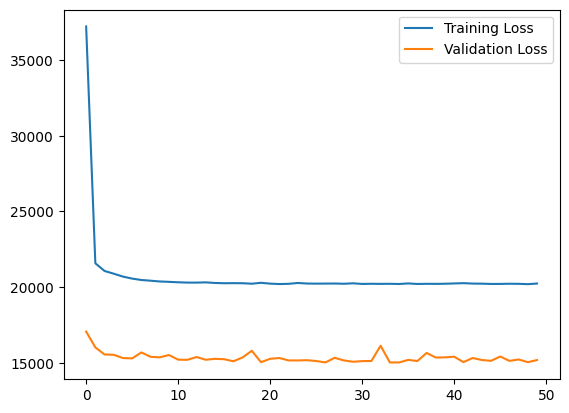

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [29]:
# 10. Neuronales Netz erstellen
neural_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Regressionsausgabe
])

# Modell kompilieren
neural_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Modell trainieren
history = neural_model.fit(X_train, y_train, validation_data=(X_val, validation_data['Umsatz']), epochs=50, batch_size=32)

# Trainingsergebnisse visualisieren
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Vorhersagen auf Testdaten durchführen
y_pred = neural_model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(validation_data):
    y_pred = y_pred[:len(validation_data)]

In [30]:
# 11. Code-Verbesserung für fehlende Werte

# Numerische Variablen durch Median ersetzen
for col in merged_data.select_dtypes(include=['float64', 'int64']).columns:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)

# Kategorische Variablen durch Modus ersetzen
for col in merged_data.select_dtypes(include=['object']).columns:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

C:\Users\ayham\AppData\Local\Temp\ipykernel_19372\1435289937.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].median(), inplace=True)
C:\Users\ayham\AppData\Local\Temp\ipykernel_19372\1435289937.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [31]:
# 12. Datenoptimierung

# Numerische Variablen skalieren
scaler = StandardScaler()
numeric_features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Umsatz_Trend_7_Tage']

merged_data[numeric_features] = scaler.fit_transform(merged_data[numeric_features])

# Sicherstellen, dass die Temperatur_Kategorie-Spalte vorhanden ist
if 'Temperatur_Kategorie' not in merged_data.columns:
    merged_data['Temperatur_Kategorie'] = merged_data['Temperatur'].apply(categorize_temperature)

# Kategorische Variablen kodieren
merged_data = pd.get_dummies(merged_data, columns=['Temperatur_Kategorie'], drop_first=True)

# Überprüfen, ob die Dummy-Variablen erstellt wurden
for category in ['Temperatur_Kategorie_Mild', 'Temperatur_Kategorie_Warm']:
    if category not in merged_data.columns:
        merged_data[category] = 0

# Trainings- und Validierungsdaten aktualisieren
features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Umsatz_Trend_7_Tage', 'Temperatur_Kategorie_Mild', 'Temperatur_Kategorie_Warm']

# Update train_data and validation_data with new features
train_data = merged_data[(merged_data['Datum'] >= '2013-07-01') & (merged_data['Datum'] <= '2017-07-31')]
validation_data = merged_data[(merged_data['Datum'] >= '2017-08-01') & (merged_data['Datum'] <= '2018-07-31')]

X_train = train_data[features]
y_train = train_data['Umsatz']
X_val = validation_data[features]
y_val = validation_data['Umsatz']

Epoch 1/100


c:\Users\ayham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 56981.6602 - mae: 189.5853 - val_loss: 4816.9282 - val_mae: 50.9554
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5502.2988 - mae: 52.3834 - val_loss: 2736.3882 - val_mae: 35.2200
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4934.4766 - mae: 44.0213 - val_loss: 2583.4255 - val_mae: 33.6483
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4126.0986 - mae: 42.4623 - val_loss: 2531.6565 - val_mae: 33.0003
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4748.3301 - mae: 42.9873 - val_loss: 2424.1316 - val_mae: 32.0069
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4279.1895 - mae: 41.7018 - val_loss: 2420.2476 - val_mae: 31.6742
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3740.5566 - mae: 40.0839 - val_loss: 2288.3025 - val_mae: 30.7167
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4109.0425 - mae: 40.7162 - val_loss: 2258.6013 - val_mae: 30

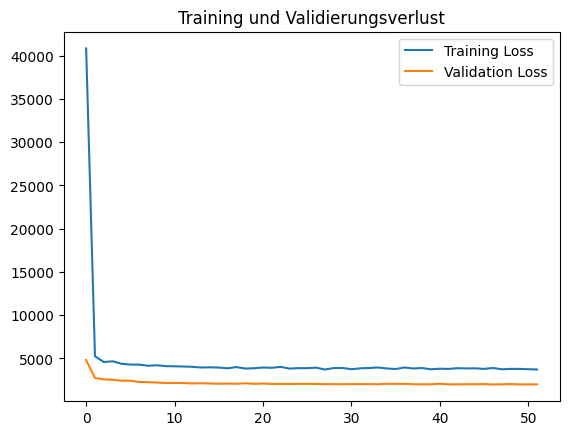

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Sample Submission aktualisiert und gespeichert als 'submission.csv'.


In [32]:
# 13. Modelloptimierung

# Neuronales Netz erstellen
neural_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Regressionsausgabe
])

# Early Stopping, um Übertraining zu verhindern
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modell kompilieren
neural_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Modell trainieren
history = neural_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           epochs=100, batch_size=32, callbacks=[early_stopping])

# Trainingsergebnisse visualisieren
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training und Validierungsverlust")
plt.show()

# Vorhersagen auf Testdaten durchführen
y_pred = neural_model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(submission):
    y_pred = y_pred[:len(submission)]

# Umsatzwerte in die Submission-Datei einfügen
submission['Umsatz'] = y_pred.flatten()

# IDs aus der sample_submission.csv wiederherstellen
submission['id'] = submission_ids

# Submission speichern
submission.to_csv("submission.csv", index=False)

print("Sample Submission aktualisiert und gespeichert als 'submission.csv'.")